# Face detection
Task is to predict the boundaries(mask) around the face in a given image.

## Dataset
Faces in images marked with bounding boxes. Have around 500 images with around 1100 faces manually tagged via bounding box.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir("drive/My Drive/Colab Notebooks")

In [ ]:
import numpy as np
data = np.load("Copy of images.npy", allow_pickle = True)

In [4]:
data[13]

array([array([[[251, 255, 254],
        [251, 255, 254],
        [251, 255, 254],
        ...,
        [159, 174, 179],
        [158, 173, 178],
        [158, 173, 178]],

       [[251, 255, 254],
        [251, 255, 254],
        [251, 255, 254],
        ...,
        [159, 174, 179],
        [158, 173, 178],
        [158, 173, 178]],

       [[251, 255, 254],
        [251, 255, 254],
        [251, 255, 254],
        ...,
        [159, 174, 179],
        [158, 173, 178],
        [158, 173, 178]],

       ...,

       [[ 72,  73,  75],
        [102, 103, 107],
        [113, 114, 118],
        ...,
        [ 50,  54,  53],
        [ 60,  65,  61],
        [ 62,  67,  63]],

       [[ 70,  72,  84],
        [ 90,  93, 102],
        [122, 122, 130],
        ...,
        [ 61,  62,  66],
        [ 78,  82,  85],
        [ 83,  87,  90]],

       [[ 85,  87,  99],
        [101, 104, 113],
        [128, 128, 136],
        ...,
        [ 72,  73,  77],
        [ 80,  84,  87],
        [ 79,  83

In [ ]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

In [6]:
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input

masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X_train = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X_train[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

In [7]:
 np.ndim(X_train)

4

In [8]:
np.ndim(masks)

3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 ...

 [[-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  ...
  [-0.96862745 -0.96862745 -0.96862745]
  [-0.96078432 -0.96078432 -0.96078432]
  [-0.96078432 -0.96078432 -0.96078432]]

 [

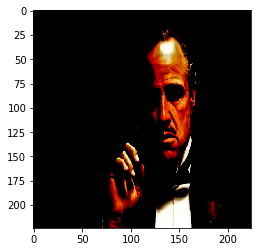

In [9]:
from matplotlib import pyplot
n = 10
print(X_train[n])
pyplot.imshow(X_train[n])

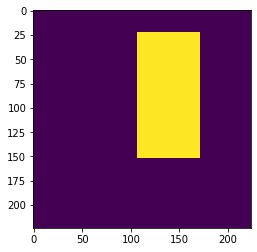

In [10]:
pyplot.imshow(masks[n])

In [ ]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape
from tensorflow.keras.models import Model


def create_model(trainable=True):
    model = MobileNet(input_shape = (IMAGE_HEIGHT,IMAGE_WIDTH,3), include_top = False, alpha = 1.0, weights = 'imagenet')
    for layer in model.layers:
        layer.trainable = trainable

    block1 = model.get_layer("conv_pw_5_relu").output
    block2 = model.get_layer("conv_pw_11_relu").output
    block3 = model.get_layer("conv_pw_13_relu").output

    x = Concatenate()([UpSampling2D()(block3), block2])
    x = Concatenate()([UpSampling2D()(x), block1])

    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    x = Reshape((28, 28))(x)

    return Model(inputs=model.input, outputs=x)

In [12]:
# Give trainable=False as argument, if you want to freeze lower layers for fast training (but low accuracy)
model = create_model()

# Print summary
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
_____________

In [ ]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tf.keras.backend.epsilon())

In [ ]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min", save_freq=1)
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

In [17]:
model.fit(x = X_train, epochs=32, batch_size = 1, verbose = True, shuffle = 2, callbacks= [checkpoint, reduce_lr, stop])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 409 samples
Epoch 1/32

Epoch 00001: loss improved from inf to 1.12632, saving model to model-1.13.h5
  1/409 [..............................] - ETA: 49:19 - loss: 1.1263 - dice_coefficient: 0.7674
Epoch 00001: loss improved from 1.12632 to 0.16781, saving model to model-0.17.h5
  2/409 [..............................] - ETA: 25:36 - loss: 0.6471 - dice_coefficient: 0.8563
Epoch 00001: loss improved from 0.16781 to 0.02493, saving model to model-0.02.h5
  3/409 [..............................] - ETA: 17:38 - loss: 0.4397 - dice_coefficient: 0.9014
Epoch 00001: loss improved from 0.02493 to 0.00457, saving model to model-0.00.h5
  4/409 [..............................] - ETA: 14:48 - loss: 0.3309 - dice_coefficient: 0.9257
Epoch 00001: loss improved from 0.00457 to 0.00110, saving model to model-0.00.h5
  5/409 [..............................] - ETA: 12:13 - loss: 0.2649 - dice_coeffic

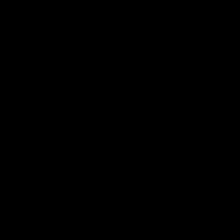

In [21]:
n = 10
sample_image = X_train[n]

from google.colab.patches import cv2_imshow

image = cv2.resize(sample_image, (IMAGE_WIDTH, IMAGE_HEIGHT))
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

region = model.predict(x=np.array([feat_scaled]))[0]

output = np.zeros(sample_image.shape[:2], dtype=np.uint8)
for i in range(region.shape[1]):
    for j in range(region.shape[0]):
        if region[i][j] > 0.8:
            x = int(CELL_WIDTH * j * unscaled.shape[1] / IMAGE_WIDTH)
            y = int(CELL_HEIGHT * i * unscaled.shape[0] / IMAGE_HEIGHT)
            x2 = int(CELL_WIDTH * (j + 1) * unscaled.shape[1] / IMAGE_WIDTH)
            y2 = int(CELL_HEIGHT * (i + 1) * unscaled.shape[0] / IMAGE_HEIGHT)
            cv2.rectangle(sample_image, (x, y), (x2, y2), (0, 255, 0), 1)

            output[y:y2,x:x2] = 1

_, contours, _ = cv2.findContours(output, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
for cnt in contours:
    approx = cv2.approxPolyDP(cnt, EPSILON * cv2.arcLength(cnt, True), True)
    x, y, w, h = cv2.boundingRect(approx)
    cv2.rectangle(sample_image, (x, y), (x + w, y + h), (0, 255, 0), 1)

cv2_imshow(sample_image)

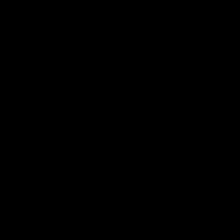

In [22]:
image = cv2.resize(sample_image, (IMAGE_WIDTH, IMAGE_HEIGHT))
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

pred_mask = cv2.resize(1.0*(model.predict(x=np.array([feat_scaled]))[0] > 0.5), (IMAGE_WIDTH,IMAGE_HEIGHT))

image2 = image
image2[:,:,0] = pred_mask*image[:,:,0]
image2[:,:,1] = pred_mask*image[:,:,1]
image2[:,:,2] = pred_mask*image[:,:,2]

out_image = image2

cv2_imshow(out_image)